# Predicting flight delays  
Larry Finer  
February 2019

The goal of this project was to predict which flights would be delayed based on month of the year, day of the week, time of day, length of flight in miles or time, airline, departure airport, arrival airport, and weather. The project entailed downloading flight and weather data, cleaning the data, and then testing several classification models to find the best one. Because both precision and recall are relevant, I used F1 as my key metric.

## Outline of work

0. [Imports and other setup](#0)
1. [Data wrangling](#1)
    1. [Airport data](#1A)
    2. [Airline data](#1B)
    3. [Flight data](#1C)
    4. [Weather data](#1D)
    5. [Merge airline and airport data into flight data](#1E)
    6. [Merge in weather data for each flight](#1F)
2. [Exploratory data analysis](#2)
3. [Classification models](#3)
    1. [Prepare data for models](#3A)
    2. [Logistic regression](#3B)
    3. [Random forest classifier](#3C)

## <a id="0"></a>0. Imports and other setup

In [1]:
import time
import os
import re
from collections import Counter
import urllib.request
import pandas as pd
from pandas.api.types import CategoricalDtype
pd.set_option('display.max_rows', 1000)
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve, f1_score, fbeta_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, 
                              AdaBoostClassifier, BaggingRegressor)

## <a id="1"></a>1. Data wrangling

Raw CSV files come from Kaggle.  
Source page: https://www.kaggle.com/usdot/flight-delays/  
Source file: https://www.kaggle.com/usdot/flight-delays/downloads/flight-delays.zip/1  
This file was downloaded and unzipped.  
The contents are the CSV files that are read in below.

### <a id="1A"></a>1A. Airport data

In [152]:
# Read in AIRPORT data.
airports = pd.read_csv('../data/airports/airports.csv')

In [153]:
airports.shape

(322, 7)

In [155]:
# All values of country are 'USA', so drop country column.
airports.drop('COUNTRY', axis=1, inplace=True)

In [154]:
# Rename columns to more user-friendly names.
airports.rename(columns={'IATA_CODE': 'iata', 'AIRPORT':'airport', 'CITY': 'city', 'STATE': 'state', 
                         'LATITUDE': 'lat', 'LONGITUDE': 'long'}, inplace=True)

In [156]:
# Read in weather station codes.
codes = pd.read_csv('../data/airports/isd-history-filtered.csv', 
                    usecols=['usaf', 'wban', 'iata'])

In [157]:
# Merge in weather station codes.
airports = airports.merge(codes, how='left', left_on='iata', right_on='iata')

In [158]:
airports.columns

Index(['iata', 'airport', 'city', 'state', 'lat', 'long', 'usaf', 'wban'], dtype='object')

In [159]:
# Clean up weather station codes.
airports.loc[airports.usaf.isnull(), 'usaf'] = "999999"
airports.loc[airports.wban.isnull(), 'wban'] = "99999"
airports['wban'] = airports['wban'].astype(int)
airports['wban'] = airports['wban'].apply(str)
airports['wban'] = airports['wban'].apply(lambda x: x.zfill(5))

In [161]:
# Generate and merge in airport dummies.
airports_without_dummies = airports
airport_dummies = pd.get_dummies(airports_without_dummies['iata'])
airports_with_dummies = airports_without_dummies.merge(airport_dummies, left_index=True, right_index=True)

In [163]:
# Pickle files for quicker reloading.
pickle.dump(airports_without_dummies, open('../data/airports/Airports without dummies.pickle', 'wb'))
pickle.dump(airports_with_dummies, open('../data/airports/Airports with dummies.pickle', 'wb'))

In [164]:
airports_with_dummies.head()

,iata,airport,city,state,lat,long,usaf,wban,ABE,ABI,...,TYS,UST,VEL,VLD,VPS,WRG,WYS,XNA,YAK,YUM
0,ABE,Lehigh Valley International Airport,Allentown,PA,40.65236,-75.44040,725170,14737,1,0,...,0,0,0,0,0,0,0,0,0,0
1,ABI,Abilene Regional Airport,Abilene,TX,32.41132,-99.68190,722660,13962,0,1,...,0,0,0,0,0,0,0,0,0,0
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,35.04022,-106.60919,723650,23050,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,45.44906,-98.42183,726590,14929,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ABY,Southwest Georgia Regional Airport,Albany,GA,31.53552,-84.19447,722160,13869,0,0,...,0,0,0,0,0,0,0,0,0,0


In [165]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322 entries, 0 to 321
Data columns (total 8 columns):
iata       322 non-null object
airport    322 non-null object
city       322 non-null object
state      322 non-null object
lat        322 non-null float64
long       322 non-null float64
usaf       322 non-null object
wban       322 non-null object
dtypes: float64(2), object(6)
memory usage: 32.6+ KB


In [170]:
col_names = ['tvc', 'fws', 'wban', 'date', 'time', 'source', 'lat', 'long', 'type',
             'elev', 'call', 'quality', 'wind_angle', 'wind_quality', 'wind_type', 
             'wind_speed', 'wind_speed_quality', 'ceiling', 'ceiling_quality', 
             'ceiling_method', 'cavok', 'vis', 'vis_quality', 'vis_var', 
             'vis_var_quality', 'temp', 'temp_quality', 'dew', 'dew_quality', 
             'pressure', 'pressure_quality', 'addl']

col_widths = [4, 6, 5, 8, 4, 1, 6, 7, 5, 5, 5, 4, 3, 1, 1, 4, 
                 1, 5, 1, 1, 1, 6, 1, 1, 1, 5, 1, 5, 1, 5, 1, 637]

In [1]:
# Download weather file for each airport.
for index, row in airports.iterrows():
    if row['usaf'] == '999999': 
        continue
    url = 'ftp://ftp.ncdc.noaa.gov/pub/data/noaa/2015/' + row['usaf'] + '-' + row['wban'] + '-2015.gz'  
    fileandext = '../data/weather/hourly/ASOS/data/' + row['usaf'] + '-' + row['wban'] + '-2015.gz'
    print(url)
    print(fileandext)

    # Comment following lines out after data are extracted
    urllib.request.urlretrieve(url, file)
    os.system('gunzip ' + file)
    file = fileandext[:-3]
    weather = pd.read_fwf(file, widths=col_widths, names=col_names)
    os.system('rm ' + file)

    try:
        weather = pickle.load(open(file + '.pickle', 'rb'))
    except:
        pass
        #urllib.request.urlretrieve(url, file)
        # os.system('gunzip ' + file)
       # weather = pd.read_fwf(file, widths=col_widths, names=col_names)
        
    # print(type(weather))
    weather['year'] = weather['date']//10000
    weather['month'] = (weather['date'] - weather['year']*10000)//100
    weather['day'] = (weather['date'] - (weather['year']*10000 + weather['month']*100))

    weather['hour'] = weather['time']//100
    weather['minute'] = weather['time'] - weather['hour']*100

    weather['datetime'] = pd.to_datetime(weather.year.astype(str) 
                                     + '-' + weather.month.astype(str) 
                                     + '-' + weather.day.astype(str) 
                                     + ' ' + weather.hour.astype(str) 
                                     + ':' +  weather.minute.astype(str))

    weather['iata'] = row['iata']

    if index == 0:
        weathermaster = weather
        
    weathermaster = weathermaster.append(weather)

    # Pickle file for quicker reloading.
    pickle.dump(weather, open(file + '.pickle', 'wb'))



In [175]:
# Pickle weather file for later reloading.
pickle.dump(weathermaster, open('../data/weather/hourly/ASOS/data/weathermaster original.pickle', 'wb'))

In [112]:
# Load weather file from pickle.
weathermaster = pickle.load(open('../data/weather/hourly/ASOS/data/weathermaster original.pickle', 'rb'))

In [176]:
weathermaster.columns

Index(['tvc', 'fws', 'wban', 'date', 'time', 'source', 'lat', 'long', 'type',
       'elev', 'call', 'quality', 'wind_angle', 'wind_quality', 'wind_type',
       'wind_speed', 'wind_speed_quality', 'ceiling', 'ceiling_quality',
       'ceiling_method', 'cavok', 'vis', 'vis_quality', 'vis_var',
       'vis_var_quality', 'temp', 'temp_quality', 'dew', 'dew_quality',
       'pressure', 'pressure_quality', 'addl', 'year', 'month', 'day', 'hour',
       'minute', 'datetime', 'iata'],
      dtype='object')

In [177]:
# Clean up weather variables.
weathermaster.loc[weathermaster['wind_speed'] == 9999, 'wind_speed'] = None
weathermaster['wind_speed'] = weathermaster['wind_speed'] / 10

weathermaster.loc[weathermaster['ceiling'] == 99999, 'ceiling'] = None

weathermaster.loc[weathermaster['vis'] == 999999, 'vis'] = None

weathermaster.loc[weathermaster['temp'] == 9999, 'temp'] = None
weathermaster['temp'] = weathermaster['temp'] / 10

weathermaster.loc[weathermaster['dew'] == 999999, 'dew'] = None
weathermaster['dew'] = weathermaster['dew'] / 10

weathermaster.loc[weathermaster['pressure'] == 99999, 'pressure'] = None
weathermaster['pressure'] = weathermaster['pressure'] / 10

In [149]:
"""
def precipitation(mystring):
    if re.search(r'AA1[0-9]*', mystring):
        return re.search(r'AA1[0-9]*', mystring).group()
    else:
        return np.nan

weathermaster['addl'].map(lambda x: precipitation(x))
# weathermaster['addl'].map(lambda x: x)
"""

"\ndef precipitation(mystring):\n    if re.search(r'AA1[0-9]*', mystring):\n        return re.search(r'AA1[0-9]*', mystring).group()\n    else:\n        return np.nan\n\nweathermaster['addl'].map(lambda x: precipitation(x))\n# weathermaster['addl'].map(lambda x: x)\n"

In [178]:
weathermaster['aa1'] = weathermaster['addl'].str[3:6]
weathermaster['precip'] = weathermaster['addl'].str[8:12]
weathermaster.loc[weathermaster.aa1 != 'AA1', 'precip'] = np.nan
pd.options.display.max_rows = 999
weathermaster.loc[weathermaster['precip'] == '9999', 'precip'] = np.nan
weathermaster['precip'] = (weathermaster['precip'].astype(float))/10

In [180]:
pickle.dump(weathermaster, open('../data/weather/hourly/ASOS/data/weathermaster.pickle', 'wb'))

### <a id="1B"></a>1B. Airline data

In [22]:
# Read in AIRLINE data.
airlines = pd.read_csv('../data/airlines/airlines.csv')

In [23]:
airlines.shape

(14, 2)

In [24]:
airlines.columns

Index(['IATA_CODE', 'AIRLINE'], dtype='object')

In [25]:
# Rename columns to friendlier names.
airlines.rename(columns={'IATA_CODE': 'airlinecode2', 
                       'AIRLINE':'airline_orig'}, 
               inplace=True)

In [26]:
# Clean up / simplify airline names.
airlines['airline'] = airlines.airline_orig.str.split().str[0]
airlines.airline = airlines.airline.str.strip()
airlines.drop('airline_orig', axis=1, inplace=True)

airlines.loc[airlines['airlinecode2'] == 'US', 'airline'] = 'US Airways'
airlines.loc[airlines['airlinecode2'] == 'EV', 'airline'] = 'Atlantic SE'
airlines.loc[airlines['airlinecode2'] == 'MQ', 'airline'] = 'Amer Eagle'

In [27]:
# Generate airline dummies.
airline_dummies = pd.get_dummies(airlines['airlinecode2'], prefix='airline')
airlines = airlines.merge(airline_dummies, left_index=True, right_index=True)

In [28]:
airlines.columns

Index(['airlinecode2', 'airline', 'airline_AA', 'airline_AS', 'airline_B6',
       'airline_DL', 'airline_EV', 'airline_F9', 'airline_HA', 'airline_MQ',
       'airline_NK', 'airline_OO', 'airline_UA', 'airline_US', 'airline_VX',
       'airline_WN'],
      dtype='object')

In [29]:
airlines

,airlinecode2,airline,airline_AA,airline_AS,airline_B6,airline_DL,airline_EV,airline_F9,airline_HA,airline_MQ,airline_NK,airline_OO,airline_UA,airline_US,airline_VX,airline_WN
0,UA,United,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,AA,American,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,US,US Airways,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,F9,Frontier,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,B6,JetBlue,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,OO,Skywest,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6,AS,Alaska,0,1,0,0,0,0,0,0,0,0,0,0,0,0
7,NK,Spirit,0,0,0,0,0,0,0,0,1,0,0,0,0,0
8,WN,Southwest,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,DL,Delta,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [30]:
# Pickle file for quicker reloading.
pickle.dump(airlines, open('../data/airlines/Airlines.pickle', 'wb'))

### <a id="1c"></a>1C. Flight data

In [129]:
# Flights
flights = pd.read_csv('../data/flights/raw/flights.csv')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [130]:
# Pickle file for quicker reloading
pickle.dump(flights, open('../data/flights/flights1.pickle', 'wb'))

In [31]:
# Un-pickle file.
flights = pickle.load(open('../data/flights/flights1.pickle', 'rb'))

In [32]:
flights.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
      dtype='object')

In [33]:
# Rename columns to friendlier names.
flights.rename(columns={'YEAR': 'year', 'MONTH':'month', 'DAY': 'day', 'DAY_OF_WEEK': 'dow', 
                        'AIRLINE': 'airlinecode', 'FLIGHT_NUMBER': 'num', 'TAIL_NUMBER': 'tail', 
                        'ORIGIN_AIRPORT': 'origin', 'DESTINATION_AIRPORT': 'dest', 
                        'SCHEDULED_DEPARTURE': 'depsch', 'DEPARTURE_TIME': 'depact', 
                        'DEPARTURE_DELAY': 'depdel', 'TAXI_OUT': 'taxiout', 'WHEELS_OFF': 'wheelsoff', 
                        'SCHEDULED_TIME': 'timesch', 'ELAPSED_TIME': 'timeact', 'AIR_TIME': 'timeair', 
                        'DISTANCE': 'dist', 'WHEELS_ON': 'wheelson', 'TAXI_IN': 'taxiin', 
                        'SCHEDULED_ARRIVAL': 'arrsch', 'ARRIVAL_TIME': 'arract', 'ARRIVAL_DELAY': 'arrdel', 
                        'DIVERTED': 'diverted', 'CANCELLED': 'cancelled', 'CANCELLATION_REASON': 'cancreason',
                        'AIR_SYSTEM_DELAY': 'delsys', 'SECURITY_DELAY': 'delsec', 'AIRLINE_DELAY': 'delline',
                        'LATE_AIRCRAFT_DELAY': 'dellate', 'WEATHER_DELAY': 'delwea'}, inplace=True)

In [34]:
flights.shape

(5819079, 31)

In [36]:
flights['origin'] = flights['origin'].astype(str)

##### Distance

In [37]:
# Make categorical variable for distance.
bins = pd.IntervalIndex.from_tuples([(0, 350), (350, 700), (700, 1200), (1200, 2000), (2000, 5000)])
flights['distcat'] = pd.cut(flights.dist, bins)

In [38]:
# Make dummies for distance.
dist_dummies = pd.get_dummies(flights['distcat'], prefix='dist')
flights = flights.merge(dist_dummies, left_index=True, right_index=True)

##### Day of week

In [39]:
flights.dow.value_counts().sort_index()
# No missing values

1    865543
2    844600
3    855897
4    872521
5    862209
6    700545
7    817764
Name: dow, dtype: int64

In [40]:
# Switch to US convention where 1 = Sunday and 7 = Saturday
flights.dow += 1
flights.loc[flights.dow == 8, 'dow'] = 1

In [41]:
# Replace numbers with day abbreviations.
days = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
for day in range(7):
    flights.loc[flights.dow == day + 1, 'dow'] = days[day]

In [42]:
# Make variable categorical.
dow_cats = CategoricalDtype(categories=list(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']), ordered=True)
flights['dow'] = flights['dow'].astype(dow_cats)

In [43]:
flights.dow.value_counts().sort_index()

Sun    817764
Mon    865543
Tue    844600
Wed    855897
Thu    872521
Fri    862209
Sat    700545
Name: dow, dtype: int64

In [44]:
# Make day-of-week dummies.
dow_dummies = pd.get_dummies(flights['dow'], prefix='dow')
flights = flights.merge(dow_dummies, left_index=True, right_index=True)

In [45]:
flights.columns

Index(['year', 'month', 'day', 'dow', 'airlinecode', 'num', 'tail', 'origin',
       'dest', 'depsch', 'depact', 'depdel', 'taxiout', 'wheelsoff', 'timesch',
       'timeact', 'timeair', 'dist', 'wheelson', 'taxiin', 'arrsch', 'arract',
       'arrdel', 'diverted', 'cancelled', 'cancreason', 'delsys', 'delsec',
       'delline', 'dellate', 'delwea', 'distcat', 'dist_(0, 350]',
       'dist_(350, 700]', 'dist_(700, 1200]', 'dist_(1200, 2000]',
       'dist_(2000, 5000]', 'dow_Sun', 'dow_Mon', 'dow_Tue', 'dow_Wed',
       'dow_Thu', 'dow_Fri', 'dow_Sat'],
      dtype='object')

##### Actual departure time

In [46]:
# Count records with no actual departure time.
flights.depact.isnull().sum()

86153

In [47]:
# There are 86153 records with no actual departure time. Delete them.
flights = flights[flights.depact.notnull()]

In [48]:
flights.arract.isnull().sum()

6360

In [52]:
# There are still 6360 records with no actual arrival time. Delete them.
flights = flights[flights.arract.notnull()]

In [53]:
# Find 99th %ile.
flights.depdel.quantile(.99)

167.0

In [54]:
flights.arrdel.quantile(.99)

167.0

In [55]:
# Rein in outliers
for delvar in ['depdel', 'arrdel']:
    flights.loc[flights[delvar] >= 180, delvar] = 180

##### Date/time variables

In [56]:
# Convert some date/time variables to datetime format.
for datevar in ['depsch', 'wheelsoff', 'wheelson', 'arrsch',]:
    print(datevar)
    flights['hour'] = flights[datevar] // 100
    flights['minute'] = flights[datevar] % 100
    flights[datevar] = pd.to_datetime(flights[['year', 'month', 'day', 'hour', 'minute']])

depsch
wheelsoff
wheelson
arrsch


In [57]:
# Overwrite depact and arract based on depsch and depdel.

# Convert depdel and arrdel to timedeltas.
for deltavar in ['depdel', 'arrdel']:
    flights[deltavar] = pd.to_timedelta(flights[deltavar], unit='minutes')

flights.depact = flights.depsch + flights.depdel
flights.arract = flights.arrsch + flights.arrdel

In [58]:
# Generate 'delayed' variables.
flights['depwasdel'] = 0
flights['arrwasdel'] = 0
flights.loc[flights['depdel'] >= pd.to_timedelta('15 minutes'), 'depwasdel'] = 1
flights.loc[flights['arrdel'] >= pd.to_timedelta('15 minutes'), 'arrwasdel'] = 1
# flights['depwasdel'] = (flights['depdel'] >= pd.to_timedelta('15 minutes'))
# flights['arrwasdel'] = (flights['arrdel'] >= pd.to_timedelta('15 minutes'))

In [59]:
flights.depwasdel.value_counts(normalize=True)

0    0.815926
1    0.184074
Name: depwasdel, dtype: float64

In [60]:
flights.arrwasdel.value_counts(normalize=True)

0    0.814297
1    0.185703
Name: arrwasdel, dtype: float64

##### Hour of day

In [61]:
Convert hours from numeric to labels.
hourslist = ['12m', '1a', '2a', '3a', '4a', '5a', '6a', '7a', '8a', '9a', '10a', '11a', '12n', '1p', '2p', '3p', '4p', '5p', '6p', '7p', '8p', '9p', '10p', '11p']
flights['houro'] = flights['hour']
for hour in range(24):
    flights.loc[flights['houro'] == hour, 'houro'] = hourslist[hour]

In [62]:
# Drop the few weird cases where hour = 24.
flights.drop(flights[flights.hour == 24].index, inplace=True)

In [63]:
# Create categorical variable.
houro_cats = CategoricalDtype(categories=list(['6a', '7a', '8a', '9a', '10a', '11a', '12n', '1p', '2p', '3p', '4p', '5p', '6p', '7p', '8p', '9p', '10p', '11p', '12m', '1a', '2a', '3a', '4a', '5a']), ordered=True)
flights['houro'] = flights['houro'].astype(houro_cats)

##### Dummies for hour of day

In [64]:
# Make hour dummies.
hour_dummies = pd.get_dummies(flights['hour'], prefix='hour')
flights = flights.merge(hour_dummies, left_index=True, right_index=True)

##### Dummies for month of year

In [65]:
# Make month dummies.
month_dummies = pd.get_dummies(flights['month'], prefix='month')
flights = flights.merge(month_dummies, left_index=True, right_index=True)

#### Last steps

In [66]:
# Drop columns I'm not currently using.
flights.drop(columns=['taxiout', 'wheelsoff', 'timesch', 'timeact', 
                      'timeair', 'wheelson', 'taxiin', 'diverted', 
                     'cancelled', 'cancreason', 'delsys', 'delsec', 
                     'delline', 'dellate', 'delwea'], inplace=True)

In [67]:
# Pickle file for quicker reloading.
pickle.dump(flights, open('../data/flights/flights2.pickle', 'wb'))

In [3]:
# Reload pickle file.
flights = pickle.load(open('../data/flights/flights2.pickle', 'rb'))

In [4]:
# Take a sample of 1 million flights.
sample = flights.sample(1000000)

In [5]:
# Pickle file for quicker reloading
pickle.dump(sample, open('../data/flights/sample2.pickle', 'wb'))

# sample.to_excel('../data/flights/sample1.xlsx')

### <a id="1E"></a>1E. Merge airline and airport data into flight data

In [2]:
# Un-pickle files.
flights = pickle.load(open('../data/flights/sample2.pickle', 'rb'))
# flights = pickle.load(open('../data/flights/flights2.pickle', 'rb'))

In [3]:
airlines = pickle.load(open('../data/airlines/Airlines.pickle', 'rb'))
# airports = pickle.load(open('../data/airports/Airports with dummies.pickle', 'rb'))

In [4]:
# Merge in airline data.
flights = flights.merge(airlines, left_on = 'airlinecode', right_on = 'airlinecode2')
flights.drop('airlinecode2', axis=1, inplace=True)

In [6]:
# Merge in airport data for both origin and destination airports.
for location in ['origin', 'dest']:
    airports = pickle.load(open('../data/airports/Airports with dummies.pickle', 'rb'))
    columnrenames = {}
    for column in airports:
        columnrenames[column] = location + '_' + column
    airports.rename(columns=columnrenames, inplace=True)    
    
    flights = flights.merge(airports, how = 'left', left_on = location, right_on = location + '_iata')

    # flights.drop(location + '_iata', axis=1, inplace=True)
    # print(flights.shape)

In [7]:
flights.shape

(1000000, 745)

### <a id="1F"></a>1F. Merge in weather data for each flight

In [9]:
# Sort flights data.
flights.sort_values('depsch', inplace=True)

In [10]:
# Load weather data.
weathermaster = pickle.load(open('../data/weather/hourly/ASOS/data/weathermaster.pickle', 'rb'))

In [11]:
# Sort weather data.
weathermaster.sort_values('datetime', inplace=True)

In [12]:
# Merge weather data into flights data..
flights = pd.merge_asof(flights, weathermaster, 
                        left_on='depsch', right_on='datetime', 
                        left_by='origin', right_by='iata', 
                        direction='nearest')

In [13]:
# Pickle file for quicker reloading.
pickle.dump(flights, open('../data/flights/flights3.pickle', 'wb'), protocol=4)

In [14]:
# Pickle file for quicker reloading
pickle.dump(flights, open('../data/flights/sample3.pickle', 'wb'))

## <a id="2"></a>2. Exploratory data analysis

In [288]:
# Un-pickle sample data.
flights = pickle.load(open('../data/flights/sample3.pickle', 'rb'))

In [ ]:
# OR
# Un-pickle all flight data.
flights = pickle.load(open('../data/flights/flights3.pickle', 'rb'))

In [303]:
# Create data for Tableau heatmap.
heatmap = flights.groupby(['dow', 'houro']).agg({'arrwasdel':np.mean}).reset_index()

In [304]:
# Save out heatmap data.
heatmap.to_csv('../presentation/heatmap-long.csv')
heatmap = heatmap.pivot(index='dow', columns='houro', values='arrwasdel')
heatmap.to_csv('../presentation/heatmap.csv')
heatmap

houro,6a,7a,8a,9a,10a,11a,12n,1p,2p,3p,...,8p,9p,10p,11p,12m,1a,2a,3a,4a,5a
dow,,,,,,,,,,,,,,,,,,,,,
Sun,0.135399,0.107902,0.097137,0.102036,0.106892,0.123912,0.135725,0.149039,0.150640,0.169586,...,0.240917,0.262574,0.263408,0.250284,0.255352,0.238356,0.347826,0.325000,0.179191,0.182281
Mon,0.106337,0.097123,0.107986,0.119168,0.140871,0.147400,0.160413,0.171564,0.173608,0.199339,...,0.254079,0.269694,0.268546,0.265708,0.269189,0.279279,0.212500,0.311111,0.217143,0.171028
Tue,0.106695,0.086965,0.100884,0.113864,0.130859,0.132084,0.145442,0.160593,0.162916,0.177036,...,0.243391,0.242574,0.250352,0.241884,0.237062,0.257732,0.186441,0.285714,0.211180,0.147689
Wed,0.106453,0.087201,0.109195,0.116160,0.129308,0.137562,0.139948,0.155750,0.165601,0.171849,...,0.246481,0.240182,0.227958,0.236433,0.258285,0.227778,0.112903,0.321429,0.147541,0.156667
Thu,0.106468,0.090718,0.098822,0.113811,0.127898,0.141806,0.149597,0.164459,0.172023,0.188975,...,0.267794,0.288729,0.274209,0.287431,0.278559,0.278552,0.175000,0.275000,0.186747,0.187110
Fri,0.102231,0.091158,0.098304,0.105411,0.138810,0.141828,0.154702,0.173819,0.178783,0.190459,...,0.249779,0.264609,0.260687,0.259496,0.268495,0.252252,0.240506,0.309524,0.149068,0.175824
Sat,0.112514,0.088757,0.095824,0.104077,0.115686,0.126511,0.130313,0.139075,0.152889,0.159884,...,0.217685,0.209274,0.221079,0.215753,0.256731,0.253731,0.092593,0.255814,0.167832,0.167947


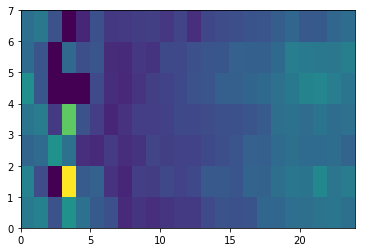

In [11]:
plt.pcolor(heatmap)
plt.show()

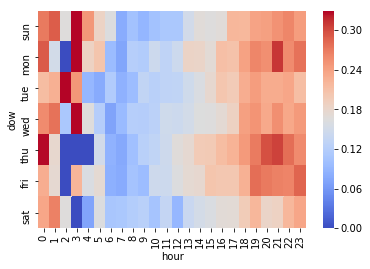

In [23]:
sns.heatmap(heatmap, vmax=.33, cmap="coolwarm")

In [ ]:
# Generate data for Tableau U.S. maps.
# By origin airport
maporigin = flights.groupby('origin_iata').aggregate({'year': 'count', 'origin_lat': np.mean, 'origin_long': np.mean, 'arrwasdel':np.mean}).reset_index()
maporigin = maporigin[['origin_iata', 'origin_lat', 'origin_long', 'year', 'arrwasdel']]
maporigin.rename(columns = {'year': 'flights'}, inplace = True)
maporigin['flights_sqrt'] = np.sqrt(maporigin['flights'])
maporigin.to_csv('../presentation/maporigin.csv')

In [60]:
# By destination airport
mapdest = flights.groupby('dest_iata').aggregate({'year': 'count', 'dest_lat': np.mean, 'dest_long': np.mean, 'arrwasdel':np.mean}).reset_index()
mapdest = mapdest[['dest_iata', 'dest_lat', 'dest_long', 'year', 'arrwasdel']]
mapdest.rename(columns = {'year': 'flights'}, inplace = True)
mapdest['flights_sqrt'] = np.sqrt(mapdest['flights'])
mapdest.to_csv('../presentation/mapdest.csv')

In [59]:
maporigin.head()

,origin_iata,origin_lat,origin_long,flights,arrwasdel,flights_sqrt
0,ABE,40.652360,-75.440400,35,0.200000,5.916080
1,ABI,32.411320,-99.681900,43,0.139535,6.557439
2,ABQ,35.040220,-106.609190,344,0.174419,18.547237
3,ABR,45.449060,-98.421830,12,0.083333,3.464102
4,ABY,31.535520,-84.194470,19,0.157895,4.358899
5,ACK,41.253050,-70.060180,7,0.000000,2.645751
6,ACT,31.611290,-97.230520,19,0.315789,4.358899
7,ACV,40.978120,-124.108620,27,0.148148,5.196152
8,ACY,39.457580,-74.577170,67,0.283582,8.185353
9,ADK,51.877960,-176.646030,2,1.000000,1.414214


In [61]:
# Look at distribution of % delayed by origin airport.
maporigin.arrwasdel.describe()

count    320.000000
mean       0.179986
std        0.108130
min        0.000000
25%        0.125000
50%        0.169132
75%        0.211831
max        1.000000
Name: arrwasdel, dtype: float64

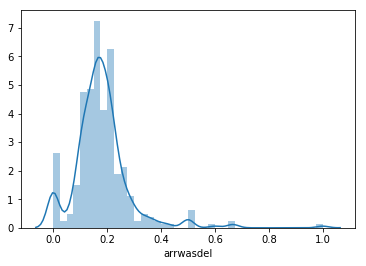

In [62]:
sns.distplot(maporigin.arrwasdel)

In [63]:
# Look at distribution of % delayed by origin airport.
mapdest.arrwasdel.describe()

count    318.000000
mean       0.180584
std        0.102467
min        0.000000
25%        0.133333
50%        0.185376
75%        0.225806
max        1.000000
Name: arrwasdel, dtype: float64

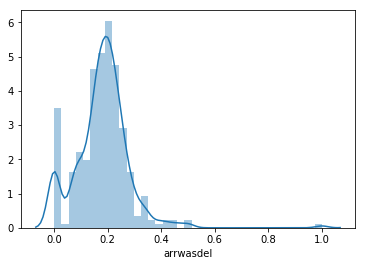

In [64]:
sns.distplot(mapdest.arrwasdel)

In [130]:
# Look at distribution of % delayed by several key variables.
for xvar in (['month', 'dow', 'hour', 'airline', 'distcat']):
    print(flights.groupby(xvar).arrwasdel.mean())

month
1     0.211231
2     0.232934
3     0.193344
4     0.170494
5     0.181553
6     0.238051
7     0.208045
8     0.183687
9     0.129838
10    0.123606
11    0.151851
12    0.204305
Name: arrwasdel, dtype: float64
dow
sun    0.181581
mon    0.197596
tue    0.181409
wed    0.179617
thu    0.200267
fri    0.193164
sat    0.159446
Name: arrwasdel, dtype: float64
hour
0     0.259995
1     0.253262
2     0.217822
3     0.201258
4     0.174455
5     0.172705
6     0.111737
7     0.090581
8     0.100312
9     0.112060
10    0.127978
11    0.133857
12    0.148941
13    0.158856
14    0.168629
15    0.177528
16    0.195706
17    0.212631
18    0.233832
19    0.243723
20    0.248957
21    0.255178
22    0.259357
23    0.258667
Name: arrwasdel, dtype: float64
airline
Alaska         0.129657
Amer Eagle     0.219346
American       0.180230
Atlantic SE    0.194404
Delta          0.133055
Frontier       0.258384
Hawaiian       0.111995
JetBlue        0.221081
Skywest        0.189140
Southwest    

In [1]:
# for xvar in (['origin']):
#     print(flights.groupby(xvar).arrwasdel.mean().sort_values())

(array([5.2420e+03, 3.9987e+04, 5.6168e+04, 6.1013e+04, 5.4542e+04,
        5.4579e+04, 5.0405e+04, 3.0707e+04, 3.7324e+04, 3.9146e+04,
        3.1968e+04, 2.1169e+04, 1.3630e+04, 9.4440e+03, 1.2615e+04,
        1.3036e+04, 7.8710e+03, 1.0917e+04, 5.3010e+03, 6.0180e+03,
        2.5370e+03, 5.2210e+03, 4.2310e+03, 4.8640e+03, 9.5960e+03,
        6.7650e+03, 2.5690e+03, 1.4270e+03, 3.9000e+02, 3.9300e+02,
        2.7000e+01, 0.0000e+00, 1.8000e+01, 1.2200e+02, 3.7000e+01]),
 array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000., 1100., 1200., 1300., 1400., 1500., 1600., 1700.,
        1800., 1900., 2000., 2100., 2200., 2300., 2400., 2500., 2600.,
        2700., 2800., 2900., 3000., 3100., 3200., 3300., 3400., 3500.]),
 <a list of 35 Patch objects>)

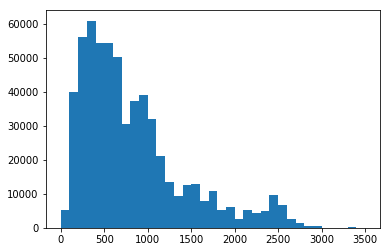

In [132]:
# Look at distribution of flights by distance traveled.
plt.hist(flights.dist, bins=35, range=(0, 3500))

In [133]:
flights.month.value_counts()

7     54594
8     52573
3     51773
6     51678
5     51109
10    50669
4     50430
12    49519
11    48969
9     48314
1     47905
2     42467
Name: month, dtype: int64

## <a id="3"></a>3. Classification models

### <a id="3A"></a>3A. Prepare data for use in models

In [26]:
# Un-pickle data.
flights = pickle.load(open('../data/flights/sample3.pickle', 'rb'))

In [16]:
# Define y (class) vector and X (features) matrix.
# First, create subset of variables that contains both y and X variables.
flights_subset = flights[['arrwasdel', 
                          
                          'airline_UA', 'airline_AA', 
                          'airline_US', 'airline_B6', 'airline_OO', 
                          'airline_AS', 'airline_NK', 'airline_WN', 
                          'airline_DL', 'airline_EV', 'airline_HA', 
                          'airline_MQ', 'airline_VX', 
                          
                          'dow_Sun', 'dow_Mon',            'dow_Wed', 
                          'dow_Thu', 'dow_Fri', 'dow_Sat', 
                          
                          'hour_1', 'hour_2', 'hour_3', 
                          'hour_5', 'hour_6', 'hour_7', 'hour_8', 
                          'hour_9', 'hour_10', 'hour_11', 'hour_12', 
                          'hour_13', 'hour_14', 'hour_15', 'hour_16', 
                          'hour_17', 'hour_18', 'hour_19', 'hour_20', 
                          'hour_21', 'hour_22', 'hour_23',  
                          
                          'month_1', 'month_2', 'month_3', 'month_4', 
                                     'month_6', 'month_7', 'month_8', 
                          'month_9', 'month_10', 'month_11', 'month_12', 
                          
                          'dist_(0, 350]', 'dist_(350, 700]', 
                          'dist_(700, 1200]', 'dist_(1200, 2000]', 
                         
                          'origin_ABE', 'origin_ABI', 'origin_ABQ', 'origin_ABR', 'origin_ABY', 'origin_ACK', 'origin_ACT', 'origin_ACV', 'origin_ACY', 'origin_ADK', 'origin_ADQ', 'origin_AEX', 'origin_AGS', 'origin_AKN', 'origin_ALB', 'origin_ALO', 'origin_AMA', 'origin_ANC', 'origin_APN', 'origin_ASE', 'origin_ATL', 'origin_ATW', 'origin_AUS', 'origin_AVL', 'origin_AVP', 'origin_AZO', 'origin_BDL', 'origin_BET', 'origin_BFL', 'origin_BGM', 'origin_BGR', 'origin_BHM', 'origin_BIL', 'origin_BIS', 'origin_BJI', 'origin_BLI', 'origin_BMI', 'origin_BNA', 'origin_BOI', 'origin_BOS', 'origin_BPT', 'origin_BQK', 'origin_BQN', 'origin_BRD', 'origin_BRO', 'origin_BRW', 'origin_BTM', 'origin_BTR', 'origin_BTV', 'origin_BUF', 'origin_BUR', 'origin_BWI', 'origin_BZN', 'origin_CAE', 'origin_CAK', 'origin_CDC', 'origin_CDV', 'origin_CEC', 'origin_CHA', 'origin_CHO', 'origin_CHS', 'origin_CID', 'origin_CIU', 'origin_CLD', 'origin_CLE', 'origin_CLL', 'origin_CLT', 'origin_CMH', 'origin_CMI', 'origin_CMX', 'origin_CNY', 'origin_COD', 'origin_COS', 'origin_COU', 'origin_CPR', 'origin_CRP', 'origin_CRW', 'origin_CSG', 'origin_CVG', 'origin_CWA', 'origin_DAB', 'origin_DAL', 'origin_DAY', 'origin_DBQ', 'origin_DCA', 'origin_DEN', 'origin_DFW', 'origin_DHN', 'origin_DIK', 'origin_DLG', 'origin_DLH', 'origin_DRO', 'origin_DSM', 'origin_DTW', 'origin_DVL', 'origin_EAU', 'origin_ECP', 'origin_EGE', 'origin_EKO', 'origin_ELM', 'origin_ELP', 'origin_ERI', 'origin_ESC', 'origin_EUG', 'origin_EVV', 'origin_EWN', 'origin_EWR', 'origin_EYW', 'origin_FAI', 'origin_FAR', 'origin_FAT', 'origin_FAY', 'origin_FCA', 'origin_FLG', 'origin_FLL', 'origin_FNT', 'origin_FSD', 'origin_FSM', 'origin_FWA', 'origin_GCC', 'origin_GCK', 'origin_GEG', 'origin_GFK', 'origin_GGG', 'origin_GJT', 'origin_GNV', 'origin_GPT', 'origin_GRB', 'origin_GRI', 'origin_GRK', 'origin_GRR', 'origin_GSO', 'origin_GSP', 'origin_GST', 'origin_GTF', 'origin_GTR', 'origin_GUC', 'origin_GUM', 'origin_HDN', 'origin_HIB', 'origin_HLN', 'origin_HNL', 'origin_HOB', 'origin_HOU', 'origin_HPN', 'origin_HRL', 'origin_HSV', 'origin_HYA', 'origin_HYS', 'origin_IAD', 'origin_IAG', 'origin_IAH', 'origin_ICT', 'origin_IDA', 'origin_ILG', 'origin_ILM', 'origin_IMT', 'origin_IND', 'origin_INL', 'origin_ISN', 'origin_ISP', 'origin_ITH', 'origin_ITO', 'origin_JAC', 'origin_JAN', 'origin_JAX', 'origin_JFK', 'origin_JLN', 'origin_JMS', 'origin_JNU', 'origin_KOA', 'origin_KTN', 'origin_LAN', 'origin_LAR', 'origin_LAS', 'origin_LAW', 'origin_LAX', 'origin_LBB', 'origin_LBE', 'origin_LCH', 'origin_LEX', 'origin_LFT', 'origin_LGA', 'origin_LGB', 'origin_LIH', 'origin_LIT', 'origin_LNK', 'origin_LRD', 'origin_LSE', 'origin_LWS', 'origin_MAF', 'origin_MBS', 'origin_MCI', 'origin_MCO', 'origin_MDT', 'origin_MDW', 'origin_MEI', 'origin_MEM', 'origin_MFE', 'origin_MFR', 'origin_MGM', 'origin_MHK', 'origin_MHT', 'origin_MIA', 'origin_MKE', 'origin_MKG', 'origin_MLB', 'origin_MLI', 'origin_MLU', 'origin_MMH', 'origin_MOB', 'origin_MOT', 'origin_MQT', 'origin_MRY', 'origin_MSN', 'origin_MSO', 'origin_MSP', 'origin_MSY', 'origin_MTJ', 'origin_MVY', 'origin_MYR', 'origin_OAJ', 'origin_OAK', 'origin_OGG', 'origin_OKC', 'origin_OMA', 'origin_OME', 'origin_ONT', 'origin_ORD', 'origin_ORF', 'origin_ORH', 'origin_OTH', 'origin_OTZ', 'origin_PAH', 'origin_PBG', 'origin_PBI', 'origin_PDX', 'origin_PHF', 'origin_PHL', 'origin_PHX', 'origin_PIA', 'origin_PIB', 'origin_PIH', 'origin_PIT', 'origin_PLN', 'origin_PNS', 'origin_PPG', 'origin_PSC', 'origin_PSE', 'origin_PSG', 'origin_PSP', 'origin_PUB', 'origin_PVD', 'origin_PWM', 'origin_RAP', 'origin_RDD', 'origin_RDM', 'origin_RDU', 'origin_RHI', 'origin_RIC', 'origin_RKS', 'origin_RNO', 'origin_ROA', 'origin_ROC', 'origin_ROW', 'origin_RST', 'origin_RSW', 'origin_SAF', 'origin_SAN', 'origin_SAT', 'origin_SAV', 'origin_SBA', 'origin_SBN', 'origin_SBP', 'origin_SCC', 'origin_SCE', 'origin_SDF', 'origin_SEA', 'origin_SFO', 'origin_SGF', 'origin_SGU', 'origin_SHV', 'origin_SIT', 'origin_SJC', 'origin_SJT', 'origin_SJU', 'origin_SLC', 'origin_SMF', 'origin_SMX', 'origin_SNA', 'origin_SPI', 'origin_SPS', 'origin_SRQ', 'origin_STC', 'origin_STL', 'origin_STT', 'origin_STX', 'origin_SUN', 'origin_SUX', 'origin_SWF', 'origin_SYR', 'origin_TLH', 'origin_TOL', 'origin_TPA', 'origin_TRI', 'origin_TTN', 'origin_TUL', 'origin_TUS', 'origin_TVC', 'origin_TWF', 'origin_TXK', 'origin_TYR', 'origin_TYS', 'origin_UST', 'origin_VEL', 'origin_VLD', 'origin_VPS', 'origin_WRG', 'origin_WYS', 'origin_XNA', 'origin_YAK', 'origin_YUM', 
                          'dest_ABE', 'dest_ABI', 'dest_ABQ', 'dest_ABR', 'dest_ABY', 'dest_ACK', 'dest_ACT', 'dest_ACV', 'dest_ACY', 'dest_ADK', 'dest_ADQ', 'dest_AEX', 'dest_AGS', 'dest_AKN', 'dest_ALB', 'dest_ALO', 'dest_AMA', 'dest_ANC', 'dest_APN', 'dest_ASE', 'dest_ATL', 'dest_ATW', 'dest_AUS', 'dest_AVL', 'dest_AVP', 'dest_AZO', 'dest_BDL', 'dest_BET', 'dest_BFL', 'dest_BGM', 'dest_BGR', 'dest_BHM', 'dest_BIL', 'dest_BIS', 'dest_BJI', 'dest_BLI', 'dest_BMI', 'dest_BNA', 'dest_BOI', 'dest_BOS', 'dest_BPT', 'dest_BQK', 'dest_BQN', 'dest_BRD', 'dest_BRO', 'dest_BRW', 'dest_BTM', 'dest_BTR', 'dest_BTV', 'dest_BUF', 'dest_BUR', 'dest_BWI', 'dest_BZN', 'dest_CAE', 'dest_CAK', 'dest_CDC', 'dest_CDV', 'dest_CEC', 'dest_CHA', 'dest_CHO', 'dest_CHS', 'dest_CID', 'dest_CIU', 'dest_CLD', 'dest_CLE', 'dest_CLL', 'dest_CLT', 'dest_CMH', 'dest_CMI', 'dest_CMX', 'dest_CNY', 'dest_COD', 'dest_COS', 'dest_COU', 'dest_CPR', 'dest_CRP', 'dest_CRW', 'dest_CSG', 'dest_CVG', 'dest_CWA', 'dest_DAB', 'dest_DAL', 'dest_DAY', 'dest_DBQ', 'dest_DCA', 'dest_DEN', 'dest_DFW', 'dest_DHN', 'dest_DIK', 'dest_DLG', 'dest_DLH', 'dest_DRO', 'dest_DSM', 'dest_DTW', 'dest_DVL', 'dest_EAU', 'dest_ECP', 'dest_EGE', 'dest_EKO', 'dest_ELM', 'dest_ELP', 'dest_ERI', 'dest_ESC', 'dest_EUG', 'dest_EVV', 'dest_EWN', 'dest_EWR', 'dest_EYW', 'dest_FAI', 'dest_FAR', 'dest_FAT', 'dest_FAY', 'dest_FCA', 'dest_FLG', 'dest_FLL', 'dest_FNT', 'dest_FSD', 'dest_FSM', 'dest_FWA', 'dest_GCC', 'dest_GCK', 'dest_GEG', 'dest_GFK', 'dest_GGG', 'dest_GJT', 'dest_GNV', 'dest_GPT', 'dest_GRB', 'dest_GRI', 'dest_GRK', 'dest_GRR', 'dest_GSO', 'dest_GSP', 'dest_GST', 'dest_GTF', 'dest_GTR', 'dest_GUC', 'dest_GUM', 'dest_HDN', 'dest_HIB', 'dest_HLN', 'dest_HNL', 'dest_HOB', 'dest_HOU', 'dest_HPN', 'dest_HRL', 'dest_HSV', 'dest_HYA', 'dest_HYS', 'dest_IAD', 'dest_IAG', 'dest_IAH', 'dest_ICT', 'dest_IDA', 'dest_ILG', 'dest_ILM', 'dest_IMT', 'dest_IND', 'dest_INL', 'dest_ISN', 'dest_ISP', 'dest_ITH', 'dest_ITO', 'dest_JAC', 'dest_JAN', 'dest_JAX', 'dest_JFK', 'dest_JLN', 'dest_JMS', 'dest_JNU', 'dest_KOA', 'dest_KTN', 'dest_LAN', 'dest_LAR', 'dest_LAS', 'dest_LAW', 'dest_LAX', 'dest_LBB', 'dest_LBE', 'dest_LCH', 'dest_LEX', 'dest_LFT', 'dest_LGA', 'dest_LGB', 'dest_LIH', 'dest_LIT', 'dest_LNK', 'dest_LRD', 'dest_LSE', 'dest_LWS', 'dest_MAF', 'dest_MBS', 'dest_MCI', 'dest_MCO', 'dest_MDT', 'dest_MDW', 'dest_MEI', 'dest_MEM', 'dest_MFE', 'dest_MFR', 'dest_MGM', 'dest_MHK', 'dest_MHT', 'dest_MIA', 'dest_MKE', 'dest_MKG', 'dest_MLB', 'dest_MLI', 'dest_MLU', 'dest_MMH', 'dest_MOB', 'dest_MOT', 'dest_MQT', 'dest_MRY', 'dest_MSN', 'dest_MSO', 'dest_MSP', 'dest_MSY', 'dest_MTJ', 'dest_MVY', 'dest_MYR', 'dest_OAJ', 'dest_OAK', 'dest_OGG', 'dest_OKC', 'dest_OMA', 'dest_OME', 'dest_ONT', 'dest_ORD', 'dest_ORF', 'dest_ORH', 'dest_OTH', 'dest_OTZ', 'dest_PAH', 'dest_PBG', 'dest_PBI', 'dest_PDX', 'dest_PHF', 'dest_PHL', 'dest_PHX', 'dest_PIA', 'dest_PIB', 'dest_PIH', 'dest_PIT', 'dest_PLN', 'dest_PNS', 'dest_PPG', 'dest_PSC', 'dest_PSE', 'dest_PSG', 'dest_PSP', 'dest_PUB', 'dest_PVD', 'dest_PWM', 'dest_RAP', 'dest_RDD', 'dest_RDM', 'dest_RDU', 'dest_RHI', 'dest_RIC', 'dest_RKS', 'dest_RNO', 'dest_ROA', 'dest_ROC', 'dest_ROW', 'dest_RST', 'dest_RSW', 'dest_SAF', 'dest_SAN', 'dest_SAT', 'dest_SAV', 'dest_SBA', 'dest_SBN', 'dest_SBP', 'dest_SCC', 'dest_SCE', 'dest_SDF', 'dest_SEA', 'dest_SFO', 'dest_SGF', 'dest_SGU', 'dest_SHV', 'dest_SIT', 'dest_SJC', 'dest_SJT', 'dest_SJU', 'dest_SLC', 'dest_SMF', 'dest_SMX', 'dest_SNA', 'dest_SPI', 'dest_SPS', 'dest_SRQ', 'dest_STC', 'dest_STL', 'dest_STT', 'dest_STX', 'dest_SUN', 'dest_SUX', 'dest_SWF', 'dest_SYR', 'dest_TLH', 'dest_TOL', 'dest_TPA', 'dest_TRI', 'dest_TTN', 'dest_TUL', 'dest_TUS', 'dest_TVC', 'dest_TWF', 'dest_TXK', 'dest_TYR', 'dest_TYS', 'dest_UST', 'dest_VEL', 'dest_VLD', 'dest_VPS', 'dest_WRG', 'dest_WYS', 'dest_XNA', 'dest_YAK', 'dest_YUM', 
                          
                          'precip', 'wind_speed', 'ceiling', 'vis', 'temp', 'pressure', 'dew'
                         ]]

In [17]:
# Drop blanks.
flights_subset.dropna(inplace=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [18]:
# Define y and X.
y = flights_subset['arrwasdel']
X = flights_subset[['airline_UA', 'airline_AA', 
                          'airline_US', 'airline_B6', 'airline_OO', 
                          'airline_AS', 'airline_NK', 'airline_WN', 
                          'airline_DL', 'airline_EV', 'airline_HA', 
                          'airline_MQ', 'airline_VX', 
                          
                          'dow_Sun', 'dow_Mon',            'dow_Wed', 
                          'dow_Thu', 'dow_Fri', 'dow_Sat', 
                          
                          'hour_1', 'hour_2', 'hour_3', 
                          'hour_5', 'hour_6', 'hour_7', 'hour_8', 
                          'hour_9', 'hour_10', 'hour_11', 'hour_12', 
                          'hour_13', 'hour_14', 'hour_15', 'hour_16', 
                          'hour_17', 'hour_18', 'hour_19', 'hour_20', 
                          'hour_21', 'hour_22', 'hour_23',   
                          
                          'month_1', 'month_2', 'month_3', 'month_4', 
                                     'month_6', 'month_7', 'month_8', 
                          'month_9', 'month_10', 'month_11', 'month_12', 
                          
                          'dist_(0, 350]', 'dist_(350, 700]', 
                          'dist_(700, 1200]', 'dist_(1200, 2000]', 
                   
                                      'origin_ABI', 'origin_ABQ', 'origin_ABR', 'origin_ABY', 'origin_ACK', 'origin_ACT', 'origin_ACV', 'origin_ACY', 'origin_ADK', 'origin_ADQ', 'origin_AEX', 'origin_AGS', 'origin_AKN', 'origin_ALB', 'origin_ALO', 'origin_AMA', 'origin_ANC', 'origin_APN', 'origin_ASE', 'origin_ATL', 'origin_ATW', 'origin_AUS', 'origin_AVL', 'origin_AVP', 'origin_AZO', 'origin_BDL', 'origin_BET', 'origin_BFL', 'origin_BGM', 'origin_BGR', 'origin_BHM', 'origin_BIL', 'origin_BIS', 'origin_BJI', 'origin_BLI', 'origin_BMI', 'origin_BNA', 'origin_BOI', 'origin_BOS', 'origin_BPT', 'origin_BQK', 'origin_BQN', 'origin_BRD', 'origin_BRO', 'origin_BRW', 'origin_BTM', 'origin_BTR', 'origin_BTV', 'origin_BUF', 'origin_BUR', 'origin_BWI', 'origin_BZN', 'origin_CAE', 'origin_CAK', 'origin_CDC', 'origin_CDV', 'origin_CEC', 'origin_CHA', 'origin_CHO', 'origin_CHS', 'origin_CID', 'origin_CIU', 'origin_CLD', 'origin_CLE', 'origin_CLL', 'origin_CLT', 'origin_CMH', 'origin_CMI', 'origin_CMX', 'origin_CNY', 'origin_COD', 'origin_COS', 'origin_COU', 'origin_CPR', 'origin_CRP', 'origin_CRW', 'origin_CSG', 'origin_CVG', 'origin_CWA', 'origin_DAB', 'origin_DAL', 'origin_DAY', 'origin_DBQ', 'origin_DCA', 'origin_DEN', 'origin_DFW', 'origin_DHN', 'origin_DIK', 'origin_DLG', 'origin_DLH', 'origin_DRO', 'origin_DSM', 'origin_DTW', 'origin_DVL', 'origin_EAU', 'origin_ECP', 'origin_EGE', 'origin_EKO', 'origin_ELM', 'origin_ELP', 'origin_ERI', 'origin_ESC', 'origin_EUG', 'origin_EVV', 'origin_EWN', 'origin_EWR', 'origin_EYW', 'origin_FAI', 'origin_FAR', 'origin_FAT', 'origin_FAY', 'origin_FCA', 'origin_FLG', 'origin_FLL', 'origin_FNT', 'origin_FSD', 'origin_FSM', 'origin_FWA', 'origin_GCC', 'origin_GCK', 'origin_GEG', 'origin_GFK', 'origin_GGG', 'origin_GJT', 'origin_GNV', 'origin_GPT', 'origin_GRB', 'origin_GRI', 'origin_GRK', 'origin_GRR', 'origin_GSO', 'origin_GSP', 'origin_GST', 'origin_GTF', 'origin_GTR', 'origin_GUC', 'origin_GUM', 'origin_HDN', 'origin_HIB', 'origin_HLN', 'origin_HNL', 'origin_HOB', 'origin_HOU', 'origin_HPN', 'origin_HRL', 'origin_HSV', 'origin_HYA', 'origin_HYS', 'origin_IAD', 'origin_IAG', 'origin_IAH', 'origin_ICT', 'origin_IDA', 'origin_ILG', 'origin_ILM', 'origin_IMT', 'origin_IND', 'origin_INL', 'origin_ISN', 'origin_ISP', 'origin_ITH', 'origin_ITO', 'origin_JAC', 'origin_JAN', 'origin_JAX', 'origin_JFK', 'origin_JLN', 'origin_JMS', 'origin_JNU', 'origin_KOA', 'origin_KTN', 'origin_LAN', 'origin_LAR', 'origin_LAS', 'origin_LAW', 'origin_LAX', 'origin_LBB', 'origin_LBE', 'origin_LCH', 'origin_LEX', 'origin_LFT', 'origin_LGA', 'origin_LGB', 'origin_LIH', 'origin_LIT', 'origin_LNK', 'origin_LRD', 'origin_LSE', 'origin_LWS', 'origin_MAF', 'origin_MBS', 'origin_MCI', 'origin_MCO', 'origin_MDT', 'origin_MDW', 'origin_MEI', 'origin_MEM', 'origin_MFE', 'origin_MFR', 'origin_MGM', 'origin_MHK', 'origin_MHT', 'origin_MIA', 'origin_MKE', 'origin_MKG', 'origin_MLB', 'origin_MLI', 'origin_MLU', 'origin_MMH', 'origin_MOB', 'origin_MOT', 'origin_MQT', 'origin_MRY', 'origin_MSN', 'origin_MSO', 'origin_MSP', 'origin_MSY', 'origin_MTJ', 'origin_MVY', 'origin_MYR', 'origin_OAJ', 'origin_OAK', 'origin_OGG', 'origin_OKC', 'origin_OMA', 'origin_OME', 'origin_ONT', 'origin_ORD', 'origin_ORF', 'origin_ORH', 'origin_OTH', 'origin_OTZ', 'origin_PAH', 'origin_PBG', 'origin_PBI', 'origin_PDX', 'origin_PHF', 'origin_PHL', 'origin_PHX', 'origin_PIA', 'origin_PIB', 'origin_PIH', 'origin_PIT', 'origin_PLN', 'origin_PNS', 'origin_PPG', 'origin_PSC', 'origin_PSE', 'origin_PSG', 'origin_PSP', 'origin_PUB', 'origin_PVD', 'origin_PWM', 'origin_RAP', 'origin_RDD', 'origin_RDM', 'origin_RDU', 'origin_RHI', 'origin_RIC', 'origin_RKS', 'origin_RNO', 'origin_ROA', 'origin_ROC', 'origin_ROW', 'origin_RST', 'origin_RSW', 'origin_SAF', 'origin_SAN', 'origin_SAT', 'origin_SAV', 'origin_SBA', 'origin_SBN', 'origin_SBP', 'origin_SCC', 'origin_SCE', 'origin_SDF', 'origin_SEA', 'origin_SFO', 'origin_SGF', 'origin_SGU', 'origin_SHV', 'origin_SIT', 'origin_SJC', 'origin_SJT', 'origin_SJU', 'origin_SLC', 'origin_SMF', 'origin_SMX', 'origin_SNA', 'origin_SPI', 'origin_SPS', 'origin_SRQ', 'origin_STC', 'origin_STL', 'origin_STT', 'origin_STX', 'origin_SUN', 'origin_SUX', 'origin_SWF', 'origin_SYR', 'origin_TLH', 'origin_TOL', 'origin_TPA', 'origin_TRI', 'origin_TTN', 'origin_TUL', 'origin_TUS', 'origin_TVC', 'origin_TWF', 'origin_TXK', 'origin_TYR', 'origin_TYS', 'origin_UST', 'origin_VEL', 'origin_VLD', 'origin_VPS', 'origin_WRG', 'origin_WYS', 'origin_XNA', 'origin_YAK', 'origin_YUM', 
                                      'dest_ABI', 'dest_ABQ', 'dest_ABR', 'dest_ABY', 'dest_ACK', 'dest_ACT', 'dest_ACV', 'dest_ACY', 'dest_ADK', 'dest_ADQ', 'dest_AEX', 'dest_AGS', 'dest_AKN', 'dest_ALB', 'dest_ALO', 'dest_AMA', 'dest_ANC', 'dest_APN', 'dest_ASE', 'dest_ATL', 'dest_ATW', 'dest_AUS', 'dest_AVL', 'dest_AVP', 'dest_AZO', 'dest_BDL', 'dest_BET', 'dest_BFL', 'dest_BGM', 'dest_BGR', 'dest_BHM', 'dest_BIL', 'dest_BIS', 'dest_BJI', 'dest_BLI', 'dest_BMI', 'dest_BNA', 'dest_BOI', 'dest_BOS', 'dest_BPT', 'dest_BQK', 'dest_BQN', 'dest_BRD', 'dest_BRO', 'dest_BRW', 'dest_BTM', 'dest_BTR', 'dest_BTV', 'dest_BUF', 'dest_BUR', 'dest_BWI', 'dest_BZN', 'dest_CAE', 'dest_CAK', 'dest_CDC', 'dest_CDV', 'dest_CEC', 'dest_CHA', 'dest_CHO', 'dest_CHS', 'dest_CID', 'dest_CIU', 'dest_CLD', 'dest_CLE', 'dest_CLL', 'dest_CLT', 'dest_CMH', 'dest_CMI', 'dest_CMX', 'dest_CNY', 'dest_COD', 'dest_COS', 'dest_COU', 'dest_CPR', 'dest_CRP', 'dest_CRW', 'dest_CSG', 'dest_CVG', 'dest_CWA', 'dest_DAB', 'dest_DAL', 'dest_DAY', 'dest_DBQ', 'dest_DCA', 'dest_DEN', 'dest_DFW', 'dest_DHN', 'dest_DIK', 'dest_DLG', 'dest_DLH', 'dest_DRO', 'dest_DSM', 'dest_DTW', 'dest_DVL', 'dest_EAU', 'dest_ECP', 'dest_EGE', 'dest_EKO', 'dest_ELM', 'dest_ELP', 'dest_ERI', 'dest_ESC', 'dest_EUG', 'dest_EVV', 'dest_EWN', 'dest_EWR', 'dest_EYW', 'dest_FAI', 'dest_FAR', 'dest_FAT', 'dest_FAY', 'dest_FCA', 'dest_FLG', 'dest_FLL', 'dest_FNT', 'dest_FSD', 'dest_FSM', 'dest_FWA', 'dest_GCC', 'dest_GCK', 'dest_GEG', 'dest_GFK', 'dest_GGG', 'dest_GJT', 'dest_GNV', 'dest_GPT', 'dest_GRB', 'dest_GRI', 'dest_GRK', 'dest_GRR', 'dest_GSO', 'dest_GSP', 'dest_GST', 'dest_GTF', 'dest_GTR', 'dest_GUC', 'dest_GUM', 'dest_HDN', 'dest_HIB', 'dest_HLN', 'dest_HNL', 'dest_HOB', 'dest_HOU', 'dest_HPN', 'dest_HRL', 'dest_HSV', 'dest_HYA', 'dest_HYS', 'dest_IAD', 'dest_IAG', 'dest_IAH', 'dest_ICT', 'dest_IDA', 'dest_ILG', 'dest_ILM', 'dest_IMT', 'dest_IND', 'dest_INL', 'dest_ISN', 'dest_ISP', 'dest_ITH', 'dest_ITO', 'dest_JAC', 'dest_JAN', 'dest_JAX', 'dest_JFK', 'dest_JLN', 'dest_JMS', 'dest_JNU', 'dest_KOA', 'dest_KTN', 'dest_LAN', 'dest_LAR', 'dest_LAS', 'dest_LAW', 'dest_LAX', 'dest_LBB', 'dest_LBE', 'dest_LCH', 'dest_LEX', 'dest_LFT', 'dest_LGA', 'dest_LGB', 'dest_LIH', 'dest_LIT', 'dest_LNK', 'dest_LRD', 'dest_LSE', 'dest_LWS', 'dest_MAF', 'dest_MBS', 'dest_MCI', 'dest_MCO', 'dest_MDT', 'dest_MDW', 'dest_MEI', 'dest_MEM', 'dest_MFE', 'dest_MFR', 'dest_MGM', 'dest_MHK', 'dest_MHT', 'dest_MIA', 'dest_MKE', 'dest_MKG', 'dest_MLB', 'dest_MLI', 'dest_MLU', 'dest_MMH', 'dest_MOB', 'dest_MOT', 'dest_MQT', 'dest_MRY', 'dest_MSN', 'dest_MSO', 'dest_MSP', 'dest_MSY', 'dest_MTJ', 'dest_MVY', 'dest_MYR', 'dest_OAJ', 'dest_OAK', 'dest_OGG', 'dest_OKC', 'dest_OMA', 'dest_OME', 'dest_ONT', 'dest_ORD', 'dest_ORF', 'dest_ORH', 'dest_OTH', 'dest_OTZ', 'dest_PAH', 'dest_PBG', 'dest_PBI', 'dest_PDX', 'dest_PHF', 'dest_PHL', 'dest_PHX', 'dest_PIA', 'dest_PIB', 'dest_PIH', 'dest_PIT', 'dest_PLN', 'dest_PNS', 'dest_PPG', 'dest_PSC', 'dest_PSE', 'dest_PSG', 'dest_PSP', 'dest_PUB', 'dest_PVD', 'dest_PWM', 'dest_RAP', 'dest_RDD', 'dest_RDM', 'dest_RDU', 'dest_RHI', 'dest_RIC', 'dest_RKS', 'dest_RNO', 'dest_ROA', 'dest_ROC', 'dest_ROW', 'dest_RST', 'dest_RSW', 'dest_SAF', 'dest_SAN', 'dest_SAT', 'dest_SAV', 'dest_SBA', 'dest_SBN', 'dest_SBP', 'dest_SCC', 'dest_SCE', 'dest_SDF', 'dest_SEA', 'dest_SFO', 'dest_SGF', 'dest_SGU', 'dest_SHV', 'dest_SIT', 'dest_SJC', 'dest_SJT', 'dest_SJU', 'dest_SLC', 'dest_SMF', 'dest_SMX', 'dest_SNA', 'dest_SPI', 'dest_SPS', 'dest_SRQ', 'dest_STC', 'dest_STL', 'dest_STT', 'dest_STX', 'dest_SUN', 'dest_SUX', 'dest_SWF', 'dest_SYR', 'dest_TLH', 'dest_TOL', 'dest_TPA', 'dest_TRI', 'dest_TTN', 'dest_TUL', 'dest_TUS', 'dest_TVC', 'dest_TWF', 'dest_TXK', 'dest_TYR', 'dest_TYS', 'dest_UST', 'dest_VEL', 'dest_VLD', 'dest_VPS', 'dest_WRG', 'dest_WYS', 'dest_XNA', 'dest_YAK', 'dest_YUM', 
                    
                          'precip', 'wind_speed', 'ceiling', 'vis', 'temp', 'pressure', 'dew'
                   ]]


In [19]:
Counter(y)

Counter({0: 585593, 1: 135980})

In [21]:
# Pickle y and X for easier reloading.
y.to_pickle('../data/flights/y.pickle')
X.to_pickle('../data/flights/X.pickle')

In [2]:
# Reload y and X.
y = pd.read_pickle('../data/flights/y.pickle')
X = pd.read_pickle('../data/flights/X.pickle')

In [22]:
# Create test, train and holdout groups.
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.2, random_state=35)

In [23]:
y_train.value_counts()

0    468810
1    108448
Name: arrwasdel, dtype: int64

In [24]:
y_test.value_counts()

0    116783
1     27532
Name: arrwasdel, dtype: int64

### <a id="3B"></a>3B. Logistic regression

In [25]:
# Create, fit and score logistic model.
lm = LogisticRegressionCV(solver='lbfgs', cv=5, max_iter=1000, class_weight={0:1, 1:2}, n_jobs=-1)
lm.fit(X_train, y_train)
lm.score(X_train, y_train)

0.8120874894761094

In [26]:
# Create predicted values for training set.
prediction_hard = lm.predict(X_train)

# Look at confusion matrix.
confusion_matrix(y_train, prediction_hard)

array([[468602,    208],
       [108266,    182]])

In [27]:
# Create predicted values for test set using default threshold of 0.5.
y_predict = lm.predict(X_test)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

Default threshold:
Precision: 0.5667,   Recall: 0.0019


In [28]:
# Try a new threshold of 0.28
y_predict = (lm.predict_proba(X_test)[:,1] > 0.28)
print("Threshold of 0.28:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

Threshold of 0.28:
Precision: 0.2154,   Recall: 0.8038


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


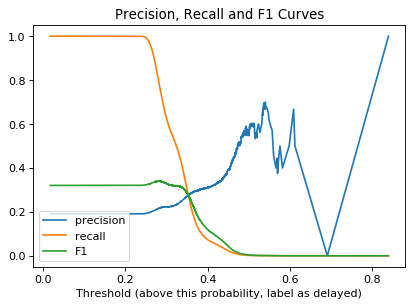

In [29]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off, as well as F1.

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lm.predict_proba(X_test)[:,1] )
f1_curve = 2/(1/recall_curve + 1/precision_curve)

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.plot(threshold_curve, f1_curve[1:], label='F1')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as delayed)');
plt.title('Precision, Recall and F1 Curves');

In [63]:
# Save these curves out to a CSV.
output = pd.DataFrame([list(threshold_curve), list(precision_curve), list(recall_curve), list(f1_curve)])
output = output.transpose()
output.to_csv('../presentation/f1.csv', header=['Threshold', 'Precision', 'Recall', 'F1'])

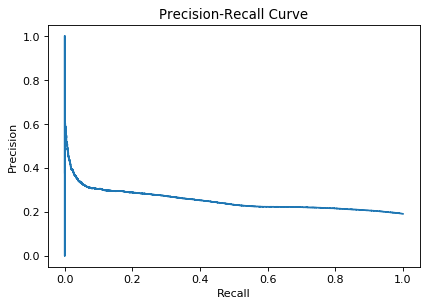

In [30]:
# Look at precision-recall curve.
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

In [31]:
# F1 score
f1_score(y_test, y_predict)

0.3397060516520204

In [32]:
# F(.5) score
fbeta_score(y_test, y_predict, beta=.5)

0.25230058552067564

In [33]:
# F2 score
fbeta_score(y_test, y_predict, beta=2)

0.5197730293906272

In [34]:
# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_test, lm.predict_proba(X_test)[:,1] > .2)

ROC AUC score =  0.4999712066131976


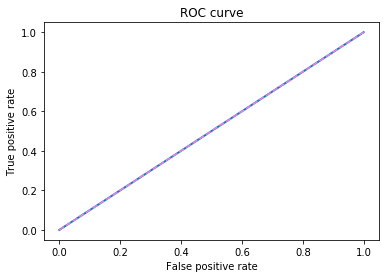

In [35]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test, lm.predict_proba(X_test)[:,1] > .2))

In [45]:
coefs = lm.coef_.tolist()[0]
xvars = list(X)
cc = list(set(zip(xvars, coefs)))
from operator import itemgetter
cc.sort(key=itemgetter(1), reverse=True)
cc

[('month_6', 0.029391309299093678),
 ('hour_21', 0.02752575440471413),
 ('wind_speed', 0.02458051444973913),
 ('hour_20', 0.02297148380659455),
 ('precip', 0.022145966755041352),
 ('month_2', 0.020698852794629664),
 ('hour_22', 0.020180878421662395),
 ('month_7', 0.01923893144174218),
 ('hour_23', 0.018513473770229227),
 ('hour_18', 0.018238488913969814),
 ('hour_19', 0.017288429791000873),
 ('dist_(700, 1200]', 0.016967316550585983),
 ('dow_Thu', 0.01601469260050024),
 ('airline_NK', 0.015632736964918487),
 ('airline_WN', 0.015142926204411974),
 ('airline_UA', 0.01497860828881971),
 ('origin_ORD', 0.013006080813348884),
 ('dest_LAX', 0.011354456767650456),
 ('airline_B6', 0.011122532770448475),
 ('hour_17', 0.011103569033248663),
 ('dow_Mon', 0.010077713582765565),
 ('airline_MQ', 0.009798512805477229),
 ('dest_LGA', 0.009690600428412209),
 ('month_1', 0.009071291467316684),
 ('dest_SFO', 0.008869810318156273),
 ('origin_LAX', 0.008557231529601805),
 ('dow_Fri', 0.008184371291697459),

### <a id="3C"></a>3C. Random forest classifier

In [18]:
# Create, fit and score an RF model.
rf = RandomForestClassifier(n_estimators=1000, max_depth=5, class_weight={0:1, 1:2}, n_jobs = -1)
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

0.8112222757955642

In [479]:
# Look at feature importances.
rf.feature_importances_

array([7.10253509e-03, 8.11865057e-03, 3.62841198e-03, 4.30612143e-03,
       6.89272328e-03, 2.75840118e-03, 3.36269936e-03, 1.00611224e-02,
       7.27993034e-03, 6.25270684e-03, 1.32802249e-03, 4.32943839e-03,
       1.90700386e-03, 1.07155561e-02, 1.04760162e-02, 1.09849114e-02,
       1.06730375e-02, 1.12986288e-02, 8.38191193e-03, 7.55108692e-04,
       2.55252251e-04, 4.13265047e-05, 1.07674483e-03, 1.78408419e-03,
       2.48484758e-03, 4.28845626e-03, 4.73850993e-03, 4.43389657e-03,
       4.59728039e-03, 4.51174959e-03, 4.67468990e-03, 5.47254828e-03,
       5.66884386e-03, 6.35701445e-03, 5.84645253e-03, 5.93396157e-03,
       5.66900357e-03, 5.63005285e-03, 5.87526380e-03, 5.32487872e-03,
       5.10879857e-03, 6.24633349e-03, 5.76516001e-03, 7.21483980e-03,
       7.26876023e-03, 6.71396386e-03, 6.87928492e-03, 7.29713762e-03,
       5.93244008e-03, 0.00000000e+00, 5.97350984e-03, 6.77160307e-03,
       1.09265746e-02, 1.23256713e-02, 1.18171973e-02, 9.00379270e-03,
      

#### RF metrics

In [19]:
rf.score(X_test, y_test)

0.8133833861413418

In [20]:
y_predict_train = rf.predict(X_train)

In [21]:
f1_score(y_train, y_predict_train)

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [22]:
y_predict_test = rf.predict(X_test)

In [23]:
f1_score(y_test, y_predict_test)

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [24]:
f1_score(y_test, y_predict, pos_label = 0)

0.45197288761842935